In [10]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point

In [24]:
import numpy as np

# Create a sample tensor
tensor = np.random.rand(32, 64, 2)

# Compute the differences along the second dimension
diff_tensor = np.diff(tensor, axis=1)

print(diff_tensor.shape)  # Output: (32, 63, 2)


(32, 63, 2)


In [28]:
import torch

# Create a sample tensor
tensor = torch.rand(32, 64, 2)

# Compute the differences along the second dimension
diff_tensor = tensor[:, 1:, :] - tensor[:, :-1, :]

print(diff_tensor.shape)  # Output: torch.Size([32, 63, 2])

/home/dingkang/envs/nlp_a4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([32, 63, 2])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, input_seq):
        _, (h, c) = self.lstm(input_seq)
        return h, c

# Define the decoder
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, h, c):
        batch_size, seq_len, _ = input_seq.shape
        z = h.reshape(batch_size, 1, -1).repeat(1, seq_len, 1)
        input_seq = torch.cat([z, input_seq], dim=-1)
        output, _ = self.lstm(input_seq, (h, c))
        output = self.fc(output)
        return output

# Define the sequence-based encoder-decoder model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq):
        h, c = self.encoder(input_seq)
        output = self.decoder(input_seq, h, c)
        return output

# Training example
input_size = 2
hidden_size = 128
output_size = 2
seq_length = 10
batch_size = 32
num_epochs = 100

# Generate random training data
train_data = torch.randn(batch_size, seq_length, input_size)

# Initialize model, loss function, and optimizer
encoder = Encoder(input_size, hidden_size)
decoder = Decoder(input_size + hidden_size, hidden_size, output_size)
model = Seq2Seq(encoder, decoder)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(train_data)
    
    # Compute loss
    loss = criterion(output, train_data)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [164]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.model_selection import train_test_split


def compute_NN(X, Y):
    X, Y = np.array(X), np.array(Y)
    neigh = NearestNeighbors(n_neighbors = 1)
    neigh.fit(X)

    knn_array = neigh.kneighbors(return_distance=False)
    knn_array = knn_array.reshape(1, -1)    # for k=1, we can flaten the array
    matches = Y[knn_array] == Y     # Match nns' labels with corresponding y
    avg_acc = matches.mean()

    return avg_acc

def compute_FT(X, Y, k=None):
    X, Y = np.array(X), np.array(Y)
    types, k_list = np.unique(Y, return_counts=True)
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(X)

    avg_acc = 0

    for i in range(len(types)):
        X_t, k = X[Y == types[i]], k_list[i]
        knn_array = neigh.kneighbors(X_t, n_neighbors=k, return_distance=False)     # Get knn for every instance
        Y_t = np.full(knn_array.shape, types[i])    # create ground truth for every nn
        matches = Y[knn_array] == Y_t    # Match knns' labels with corresponding y
        avg_acc += (matches.sum(axis=-1)/k).mean()   # Calulate acc of each row (instance) and average them

    return avg_acc/len(k_list)


def compute_ST(X, Y, k=None):
    X, Y = np.array(X), np.array(Y)
    types, k_list = np.unique(Y, return_counts=True)
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(X)

    avg_acc = 0

    for i in range(len(types)):
        X_t, k = X[Y == types[i]], k_list[i]
        knn_array = neigh.kneighbors(X_t, n_neighbors=2*k, return_distance=False)     # Now we look at top 2*k nns
        Y_t = np.full(knn_array.shape, types[i])    # create ground truth for every nn
        matches = Y[knn_array] == Y_t    # Match knns' labels with corresponding y
        avg_acc += (matches.sum(axis=-1)/k).mean()   # Calulate acc of each row (instance) and average them

    return avg_acc/len(k_list)

    # return round(correct*1.0/k, 3), knn_list

In [165]:
batch_size = 64
loaded = np.load("dataset/train_building_shape_5k.npz")

split_ratio = 0.2
train_tokens, val_tokens, train_labels, val_labels = train_test_split(loaded["train_tokens"], loaded["train_labels"], test_size=split_ratio, random_state=42)
# train_tokens, train_labels = loaded["train_tokens"], loaded["train_labels"]

train_tokens = train_tokens.reshape(train_tokens.shape[0], -1)

In [167]:
# compute_NN(train_tokens, train_labels)
compute_FT(train_tokens, train_labels), compute_ST(train_tokens, train_labels)


(0.428367780917627, 0.5544760435345489)

In [168]:
from utils.prepare_dataset import prepare_dataset_mnist
max_seq_len = 64
batch_size = 64
dataset_size = None
with_mask = False

train_tokens, train_labels, train_mask, val_tokens, val_labels, val_mask = prepare_dataset_mnist(file="dataset/building_shapes_5010.csv",
                                                                                                 with_mask=with_mask,
                                                                                                 split_ratio=0.2,
                                                                                                 dataset_size=dataset_size,
                                                                                                 max_seq_len=max_seq_len,
                                                                                                 train=True)

train_tokens = train_tokens[:, :, :2]
train_tokens = train_tokens.reshape(train_tokens.shape[0], -1)

In [169]:
compute_FT(train_tokens, train_labels), compute_ST(train_tokens, train_labels)

(0.15763092303377366, 0.257442129680529)

In [ ]:
import numpy as np

def min_max_normalize(data):
    # Compute min and max values along the num_features dimension
    min_vals = np.min(data, axis=(1, 2), keepdims=True)
    max_vals = np.max(data, axis=(1, 2), keepdims=True)
    
    # Perform min-max normalization
    a = data - min_vals
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    
    return normalized_data

# Example dataset
batch_size = 2
sequence_length = 3
num_features = 2
dataset = np.random.rand(batch_size, sequence_length, num_features)

# Normalize the dataset
normalized_dataset = min_max_normalize(dataset)

print("Original Dataset:")
print(dataset)
print("\nNormalized Dataset:")
print(normalized_dataset)


In [354]:
import pandas as pd
from shapely import wkt
from shapely.geometry import Polygon
import rasterio.features
import matplotlib.pyplot as plt



def raterize_poly(file=None, size=28):
    df = pd.read_csv(file)
    df = df[:5000]
    wkts = df['wkt'].to_numpy()
    labels = df['label'].to_numpy()

    geom_xy = [wkt.loads(wkt_str).boundary.coords.xy for wkt_str in wkts]

    imgs = np.zeros((len(geom_xy), size, size))

    for i, xy in enumerate(geom_xy):
        vec = np.array(xy).T
        min = vec.min(axis=0, keepdims=True)
        max = vec.max(axis=0, keepdims=True)

        # Map to the range [0, 1]
        vec = (vec - min) / (max - min)
        
        # zoom out 10% to ensure the integrity of the shape
        vec = vec * 0.9

        # Get centroid and shift to the center (0.5, 0.5)
        min = vec.min(axis=0, keepdims=True)
        max = vec.max(axis=0, keepdims=True)

        centroid = (max + min) / 2
        shift = (np.array([0.5, 0.5]) - centroid)[0] # remove redundant dimension

        vec[:, 0] += shift[0]
        vec[:, 1] += shift[0]

        vec = vec * size

        poly = Polygon(vec)
        img = rasterio.features.rasterize([poly], out_shape=(size, size), fill=1, default_value=0)

        imgs[i] = img

    return imgs, labels, wkts
    

# # poly = Polygon([(0, 50), (10, 10), (30, 0), (45, 45), (0, 50)])
# poly = reverse_vector_polygon(train_tokens[100]*28)
# img = rasterio.features.rasterize([poly], out_shape=(28, 28), fill=1, default_value=0)
# plt.imshow(img, cmap='gray', vmin=0, vmax=1)

In [359]:
imgs, labels, wkts = raterize_poly("dataset/building_shapes_5010.csv", 28)

# np.savez("dataset/raterized_building_shapes.npz", train_tokens=imgs, train_labels=labels)

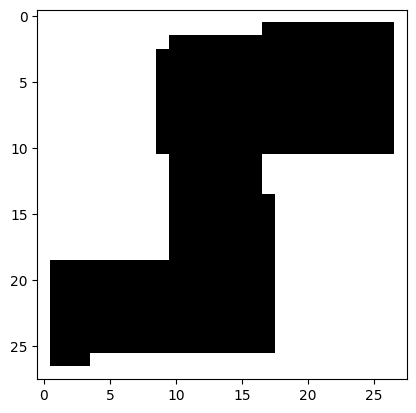

In [357]:
plt.imshow(imgs[100], cmap='gray')

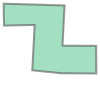

In [358]:
wkt.loads(wkts[100])

In [ ]:
def shift_to_center(vec):
    mins = vec.min(axis=0, keepdims=True)
    maxs = vec.min(axis=0, keepdims=True)

In [333]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        act_fn = nn.GELU
        self.net1 = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1),
            act_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True))
        
        self.net2 = nn.Sequential(nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1),
            act_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True))

        self.net3 = nn.Sequential(
            nn.Conv2d(18, 8, kernel_size=3, stride=1, padding=1),
            act_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1, return_indices=True),
        )

        self.flatten = nn.Flatten()


    def forward(self, x):
        x, indices1 = self.net1(x)
        x, indices2 = self.net2(x)
        x, indices3 = self.net3(x)
        x = self.flatten(x)
        return x, [indices1, indices2, indices3]
    

class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.act_fn = nn.GELU()
        self.mup1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv1 = nn.ConvTranspose2d(8, 18, kernel_size=3, stride=1, padding=1)
        self.mup2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv2 = nn.ConvTranspose2d(18, 3, kernel_size=3, stride=1, padding=1)
        self.mup3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv3 = nn.ConvTranspose2d(3, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x, indices_list):
        x = x.reshape(x.shape[0], -1, 4, 4)
        # x = self.net(x, indices_list[0])
        print(x.shape)
        x = self.mup1(x, indices_list[2], output_size=(x.shape[0], x.shape[0], 7, 7))
        x = self.act_fn(self.conv1(x))
        x = self.mup2(x, indices_list[1])
        x = self.act_fn(self.conv2(x))
        x = self.mup3(x, indices_list[0])
        x = self.act_fn(self.conv3(x))
        return x
    
class PixelNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.loss_func = nn.MSELoss()

    def forward(self, x):
        hidden = self.encoder
        output = self.decoder(hidden)
        loss = self.loss_func(x, output, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return hidden, output, loss

In [239]:
data = torch.randn(2, 1, 28, 28)

In [334]:
encoder = Encoder(nn.GELU)
decoder = Decoder()
# data = data.permute(2, 0, 1)
data.shape
encoded, indices_list = encoder(data)
decoder(encoded, indices_list).shape


torch.Size([2, 8, 4, 4])


torch.Size([2, 1, 28, 28])

In [25]:
from shapely import wkt
import pandas as pd

df = pd.read_csv("dataset/mnist_polygon_test_2k.csv")
wkts = df['wkt'].to_numpy()

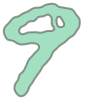

In [74]:
shape = wkt.loads(wkts[9])

In [90]:
def interpolate_polygon(polygon, num_points=64):
    """
    Interpolate simply polygon to have given number of points
    @param: shapely polygon
    @return: the interpolated polygon
   """
    num_points = 64
    sub_shapes = [polygon.exterior] + [interior for interior in polygon.interiors] if len(polygon.interiors) else [polygon.exterior]
    num_list =  [len(sub_shape.coords) for sub_shape in sub_shapes]
    total_length = sum(num_list)
    interp_num = [int(length/total_length*num_points) for length in num_list] # assin num_points according to length
    interp_num[0] += num_points - sum(interp_num) # insure the total num of points is equal to given

    interp_points = [[sub_shape.interpolate(distance) for distance in np.linspace(0, sub_shape.length, interp_num[i])]
                        for i, sub_shape in enumerate(sub_shapes)] # get interpolated points for each sub_shape

    shell = [[point.x, point.y] for point in interp_points[0]]
    holes = [[[point.x, point.y] for point in sub_points] for sub_points in interp_points[1:]] if len(interp_points) > 1 else None
    return Polygon(shell=shell, holes=holes) # create new polygon from interpolated points


In [91]:
polygon = interpolate_polygon(shape)

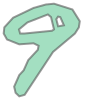

In [92]:
from utils.vectorizer import num_points_from_wkt, recursive_simplify

recursive_simplify(64, shape)

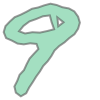

In [93]:
polygon

In [ ]:
class ConvAE(nn.Module):
    def __init__(self, fea_dim):
        super().__init__()
        self.fea_dim = fea_dim
        self.encoder = nn.Sequential(nn.Conv1d(fea_dim, 64, kernel_size=3, padding=1, stride=2),
                                     nn.ReLU(),
                                     nn.Conv1d(64, 48, kernel_size=3, padding=1),
                                     nn.ReLU(),
                                     nn.Conv1d(48, 32, kernel_size=3, padding=1, stride=2),
                                     nn.ReLU(),
                                     nn.Conv1d(32, 24, kernel_size=3, padding=1),
                                     nn.ReLU(),
                                     nn.Conv1d(24, 12, kernel_size=3, padding=1, stride=2),
                                     nn.Flatten(),
                                     nn.Linear(12*8, 64))
        
        self.decoder = nn.Sequential(nn.ConvTranspose1d(12, 24, kernel_size=3, padding=1, stride=2, output_padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose1d(24, 32, kernel_size=3, padding=1, stride=1, output_padding=0),
                                     nn.ReLU(),
                                     nn.ConvTranspose1d(32, 48, kernel_size=3, padding=1, stride=2, output_padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose1d(48, 64, kernel_size=3, padding=1, stride=1, output_padding=0),
                                     nn.ReLU(),
                                     nn.ConvTranspose1d(64, fea_dim, kernel_size=3, padding=1, stride=2, output_padding=1))
        
        self.linear = nn.Sequential(
            nn.Linear(64, 12*8),
            nn.ReLU()
        )

        self.mse_loss_func = F.mse_loss
        self.meta_loss_func = nn.CrossEntropyLoss()
        
    def forward(self, x):

        permuated_x = x.permute(0, 2, 1)  # Permute to (batch_size, channels, seq_len)
        encoded = self.encoder(permuated_x)
        # print(encoded.shape)
        decoded = self.linear(encoded).reshape(encoded.size(0), 12, 8)
        decoded = self.decoder(decoded)
        decoded = decoded.permute(0, 2, 1)

        coord_output = decoded[:, :, :2] # coord_output = decoded[:, :, :2]
        meta_output1 = decoded[:, :, 2:4]
        meta_output2 = decoded[:, :, 4:]
        target_meta1 = torch.argmax(x[:, :, 2:4], dim=-1) # inner or outer points
        target_meta2 = torch.argmax(x[:, :, 4:], dim=-1) # render one-hot code
        coord_loss = self.mse_loss_func(coord_output, x[:, :, :2], reduction="none")
        coord_loss = coord_loss.sum(dim=[1, 2]).mean(dim=[0])
        # 2 is inner or outer one-hot vocab size, 3 is render one-hot vocab size
        meta_loss1 = self.meta_loss_func(meta_output1.contiguous().view(-1, 2), target_meta1.contiguous().view(-1))
        meta_loss2 = self.meta_loss_func(meta_output2.contiguous().view(-1, 3), target_meta2.contiguous().view(-1))

        meta_indices1 = torch.argmax(meta_output1, dim=-1)
        meta_indices2 = torch.argmax(meta_output2, dim=-1)
        output = torch.cat([coord_output, nn.functional.one_hot(meta_indices1, 2), nn.functional.one_hot(meta_indices2, 3)], dim=-1)
        
        return encoded, output, coord_loss*0.25 + (meta_loss1 + meta_loss2)*0.75
        # return encoded, output, coord_loss

In [102]:
from math import cos, sin, pi

def gen_wktLiteral(assignment, nclusters, minimal_points=3):
    # target clusters get a unique shape 
    npoints = max(minimal_points, assignment+3)

    # points equally distributed around origin
    points = [np.array([nclusters * sin((2*pi*i)/npoints),
                        nclusters * cos((2*pi*i)/npoints)])
              for i in range(npoints)]

    # randomize by rotation around center as we want the shape to matter
    r = np.random.rand()
    a = 2*pi*r
    for point in points:
        x, y = point
        point[0] = y * sin(a) + x * cos(a)
        point[1] = y * cos(a) - x * sin(a)

    # centres equally distributed around origin to prevent location from
    # being a signal.
    centre_x = np.random.randn()/10
    centre_y = np.random.randn()/10

    # translate to new centres
    for point in points:
        x, y = point
        point[0] = centre_x + x
        point[1] = centre_y + y

    points_str = ["{} {}".format(x, y) for x, y in points]
    points_str.append(points_str[0])  # close polygon
    return "POLYGON ((" +\
            ", ".join(points_str) +\
            "))"

In [203]:
from shapely import wkt

def gen_float(min_value=-9e5, max_value=9e5):
    return np.random.rand() * np.random.randint(min_value, max_value)

def gen_point(min_lat=-90, max_lat=90, min_lon=-180, max_lon=180):
    return (gen_float(min_lon, max_lon), gen_float(min_lat, max_lat))

def gen_wktLiteral(min_length=15, max_length=64):
    valid_polygon = False
    while not valid_polygon:
        num_points = np.random.randint(min_length, max_length)
        points = [gen_point() for _ in range(num_points-1)]
        points_str = ["{} {}".format(lon, lat) for (lon, lat) in points]
        points_str.append(points_str[0])  # close polygon
        wkt_str = "POLYGON ((" +\
                ", ".join(points_str) +\
                "))"
        polygon = wkt.loads(wkt_str)
        if polygon.is_valid:
            valid_polygon = True

    return polygon



In [ ]:
gen_wktLiteral()

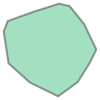

In [255]:
from polygenerator import (
    random_polygon,
    random_star_shaped_polygon,
    random_convex_polygon,
)

# this is just so that you can reproduce the same results
# random.seed(5)

polygon = random_star_shaped_polygon(num_points=32)
polygon = random_polygon(num_points=32)
polygon = random_convex_polygon(num_points=12)

from shapely.geometry import Polygon

Polygon(polygon)

<function random_polygon at 0x7d66901223b0>


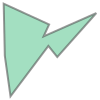

In [355]:
import random
from shapely.geometry import Polygon

# Define the list of functions and their corresponding probabilities
functions = [random_polygon, random_star_shaped_polygon, random_convex_polygon]
probabilities = [0.5, 0.35, 0.15]

# Choose a function based on the specified probabilities
chosen_function = random.choices(functions, weights=probabilities, k=1)[0]

# Run the chosen function
print(chosen_function)
if chosen_function==random_polygon:
    num_points = random.randint(3, 32)
elif chosen_function==random_star_shaped_polygon:
    num_points = random.randint(3, 32)
else:
    num_points = random.randint(3, 12)

Polygon(chosen_function(num_points))